In [5]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import keras
import tensorflow as tf

from keras.models import Sequential 
from keras.layers import Dense
from keras.layers import Flatten
from keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.applications import DenseNet121
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

In [8]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    rotation_range = 10,
                                    fill_mode='nearest',
                                    vertical_flip=True,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    brightness_range=(0.4,0.6),
                                    horizontal_flip=True,
                                    validation_split=0.3)

In [9]:
path = '/content/drive/MyDrive/data'
train_generator=train_datagen.flow_from_directory(path,
                                                    target_size=(224,224),
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    subset='training')

Found 1045 images belonging to 2 classes.


In [10]:
test_generator=train_datagen.flow_from_directory(path,
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  class_mode='binary',
                                                  subset='validation')

Found 447 images belonging to 2 classes.


In [11]:
dataset=image_dataset_from_directory(path,
                                    image_size=(224,224),
                                    batch_size=32,
                                    shuffle=True
                                    )

Found 1492 files belonging to 2 classes.


In [12]:
class_name = dataset.class_names
class_name

['non_tropical', 'tropical_forest']

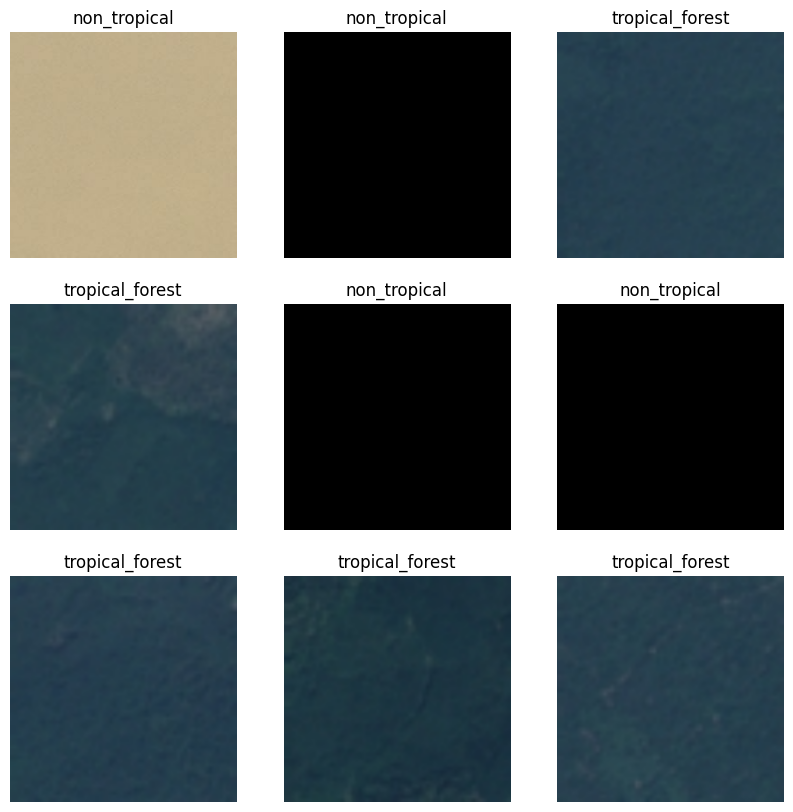

In [ ]:
plt.figure(figsize=(10, 10))
for image, label in dataset.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_name[label[i]])
        plt.axis('off')

In [13]:
#@title Densenet121 model import 
base_model = DenseNet121(
    include_top = True,
    weights = 'imagenet')

33188688/33188688 [==============================] - 2s 0us/step


In [14]:
for layer in base_model.layers:
    layer.trainable = False

In [15]:
base_model = keras.Model(inputs=base_model.input, outputs=base_model.layers[-2].output)
model = tf.keras.Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(4, activation='softmax'))

In [16]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [17]:
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [18]:
FIT = model.fit(train_generator, validation_data=test_generator, callbacks=[early], epochs=50)

Epoch 1/50
33/33 [==============================] - 323s 9s/step - loss: 0.8542 - accuracy: 0.6163 - val_loss: 0.6343 - val_accuracy: 0.6532
Epoch 2/50
33/33 [==============================] - 26s 780ms/step - loss: 0.4353 - accuracy: 0.8861 - val_loss: 0.5419 - val_accuracy: 0.7405
Epoch 3/50
33/33 [==============================] - 25s 772ms/step - loss: 0.3100 - accuracy: 0.9550 - val_loss: 0.4220 - val_accuracy: 0.8210
Epoch 4/50
33/33 [==============================] - 25s 769ms/step - loss: 0.2369 - accuracy: 0.9732 - val_loss: 0.3634 - val_accuracy: 0.8501
Epoch 5/50
33/33 [==============================] - 27s 839ms/step - loss: 0.1903 - accuracy: 0.9809 - val_loss: 0.3038 - val_accuracy: 0.9239
Epoch 6/50
33/33 [==============================] - 28s 841ms/step - loss: 0.1577 - accuracy: 0.9866 - val_loss: 0.2637 - val_accuracy: 0.9239
Epoch 7/50
33/33 [==============================] - 25s 757ms/step - loss: 0.1367 - accuracy: 0.9904 - val_loss: 0.2359 - val_accuracy: 0.9172
E

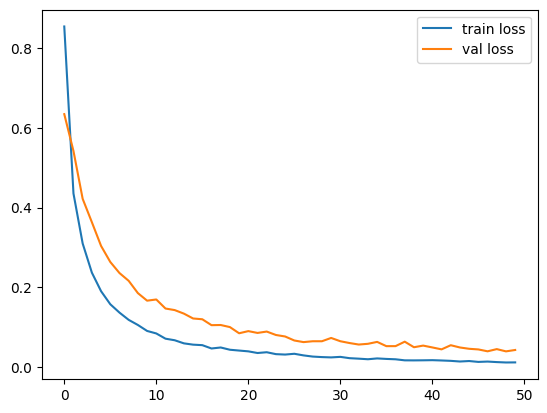

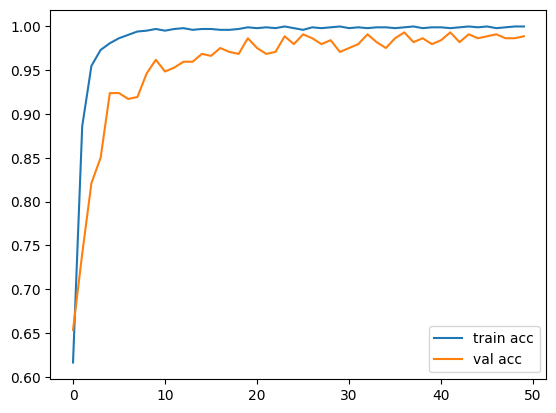

In [19]:
plt.plot(FIT.history['loss'], label='train loss')
plt.plot(FIT.history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.plot(FIT.history['accuracy'], label='train acc')
plt.plot(FIT.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [20]:
y_true = np.array([])
y_pred = np.array([])


In [21]:
i = 0
for data, labels in test_generator:
    i = i + 1
    y = np.argmax(model.predict(data), axis=1)
    
    y_true = np.append(y_true, labels)
    y_pred = np.append(y_pred, y)
    
    if i == test_generator.samples // 32 + 1: break

1/1 [==============================] - 2s 2s/step


In [ ]:
acc = accuracy_score(y_true, y_pred)
print("DenseNet121 Model Accuracy: {:.2f}%".format(acc * 100))
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1score = f1_score(y_true, y_pred)
print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"F1 Score = {f1score}")

DenseNet121 Model Accuracy: 98.44%
Precision = 0.9602510460251046
Recall = 0.9978260869565218
F1 Score = 0.9786780383795308


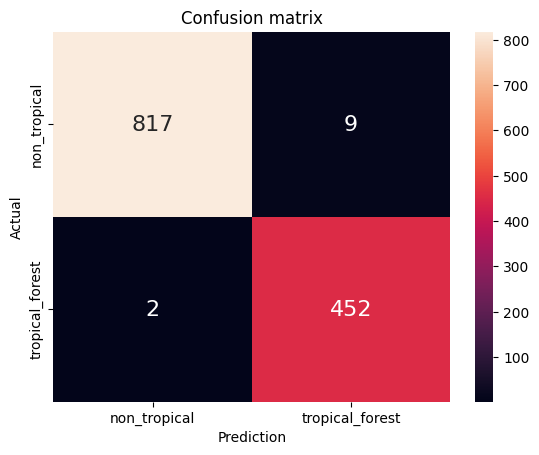

In [ ]:
from sklearn import metrics
cm =metrics.confusion_matrix(y_pred, y_true)
labels = class_name
df_cm = pd.DataFrame( cm,index=[i for i in range(2)], columns=[i for i in range(2)])
sns.heatmap(df_cm, annot=True, annot_kws={"size":16}, fmt='d', xticklabels=labels, yticklabels=labels)
plt.title('Confusion matrix')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

In [22]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_pred, y_true)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.9871794871794872

Text(0.5, 0, 'False Positive Rate')

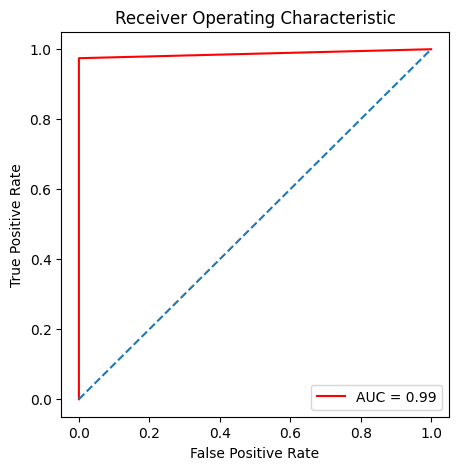

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')